In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [23]:
#imports/envi
!pip install scanpy
!pip install pydeseq2
!pip install gseapy

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from scipy.sparse import issparse
from sklearn.decomposition import PCA

import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gseapy as gp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 kB 7.1 MB/s eta 0:00:00


In [3]:
#data preprocessing
adata = sc.read('/content/drive/My Drive/MGH/aci_dims1to10_06_19_25_type_anno_precomp_v3.h5ad')

donor_col = "orig.ident"
cond_col = "AD"

In [4]:
# --- Counts matrix from adata.raw ---
X_raw = adata.raw.X
if issparse(X_raw):
    X_raw = X_raw.toarray()
df_raw = pd.DataFrame(X_raw, index=adata.obs_names, columns=adata.raw.var_names)

In [5]:
# --- Metadata with donor, condition, and region ---
meta = adata.obs.copy()
meta[donor_col] = meta[donor_col].astype(str).str.strip()

In [6]:
# Normalize condition spelling
meta["Condition"] = meta[cond_col].astype(str)
meta["Condition"] = (meta["Condition"]
                     .str.replace(r"^(Cntrl|CTRL|Ctrl)$", "Control", regex=True)
                     .str.replace(r"^(Alz|AD)$", "AD", regex=True))

In [7]:
# Extract a region label. Prefer a real column if you have it; else parse from obs_names like "BA9_2012_..."
if "region" in meta.columns:
    meta["region"] = meta["region"].astype(str).str.strip()
else:
    # crude: take the prefix up to the first underscore (e.g., "BA9", "BA20")
    meta["region"] = meta.index.to_series().str.extract(r"^([A-Za-z0-9]+)_", expand=False).fillna("UNK")

In [8]:
# Keep donor 2339 cells and all Control cells
is_2339_cell = meta[donor_col].str.contains(r"\b2339\b", na=False)
is_control   = meta["Condition"] == "Control"
keep_cells   = is_2339_cell | is_control
meta = meta.loc[keep_cells].copy()
counts = df_raw.loc[keep_cells].copy()

In [9]:
# Group label (donor 2339 vs other controls)
meta["group"] = np.where(is_2339_cell.loc[meta.index], "D2339", "Control")
meta["group"] = pd.Categorical(meta["group"], categories=["Control", "D2339"])

In [10]:
# --- Pseudobulk: sum counts per donor (across kept cells) ---
pb_cols, pb_arrays = [], []
for donor_id, idx in meta.groupby(donor_col).groups.items():
    summed = counts.loc[idx].sum(axis=0)  # 1 x genes
    pb_cols.append(str(donor_id))
    pb_arrays.append(summed.values)

counts_pb = pd.DataFrame(np.vstack(pb_arrays).T,
                         index=counts.columns,
                         columns=pb_cols)

In [11]:
# Donor-level metadata aligned to columns of counts_pb
meta_pb = (meta[[donor_col, "group", "region"]]
           .drop_duplicates(subset=[donor_col])
           .set_index(donor_col)
           .loc[counts_pb.columns]
           .copy())

In [12]:
# Filter low-count genes (sum>=10 across donors; present in >=2 donors)
keep_genes = (counts_pb.sum(axis=1) >= 10) & ((counts_pb > 0).sum(axis=1) >= 2)
counts_pb  = counts_pb.loc[keep_genes].round().astype(int)

In [13]:
# DESeq2 input (samples x genes)
counts_sxg = counts_pb.T
# Categorical types
meta_pb["group"]  = pd.Categorical(meta_pb["group"], categories=["Control", "D2339"])
meta_pb["region"] = meta_pb["region"].astype("category")

In [14]:
# Build DESeq2 dataset with region as covariate
dds = DeseqDataSet(
    counts=counts_sxg,
    metadata=meta_pb,
    design_factors=["region", "group"],   # ~ region + group
)

/tmp/ipython-input-3557710341.py:2: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [15]:
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.80 seconds.

Fitting dispersion trend curve...
... done in 0.51 seconds.

Fitting MAP dispersions...
... done in 6.49 seconds.

Fitting LFCs...
... done in 3.93 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 12361 outlier genes.

Fitting dispersions...
... done in 2.48 seconds.

Fitting MAP dispersions...
... done in 3.56 seconds.

Fitting LFCs...
... done in 2.57 seconds.



In [16]:
# Contrast: D2339 vs Control (adjusting for region)
stat_res = DeseqStats(dds, contrast=("group", "D2339", "Control"))
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: group D2339 vs Control
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.1    3.619140        0.778336  1.115427  0.697792  0.485307  0.999858
AL627309.5   10.144294       -0.315775  0.722525 -0.437044  0.662079  0.999858
AL669831.2    0.533916        0.044417  3.147815  0.014110  0.988742  0.999858
LINC01409    55.449849       -0.509127  0.533295 -0.954682  0.339739  0.999858
LINC01128    26.641975       -0.496144  0.652656 -0.760192  0.447140  0.999858
...                ...             ...       ...       ...       ...       ...
AL592183.1  186.549619       -0.443123  0.733569 -0.604064  0.545801  0.999858
AC240274.1   13.903915       -0.533108  0.867274 -0.614694  0.538757  0.999858
AC004556.3    1.097056       -3.495402  3.906647 -0.894732  0.370930  0.999858
AC007325.4   19.668578        0.981214  0.685394  1.431605  0.152257  0.999858
AC007325.2   50.789665       -0.493019  0.643209 -0.766499  0.443380  

... done in 1.63 seconds.



In [17]:
# Results table with gene names column
res = stat_res.results_df
res = res[res.baseMean >= 10].copy()
res = res.reset_index().rename(columns={"index": "gene"})

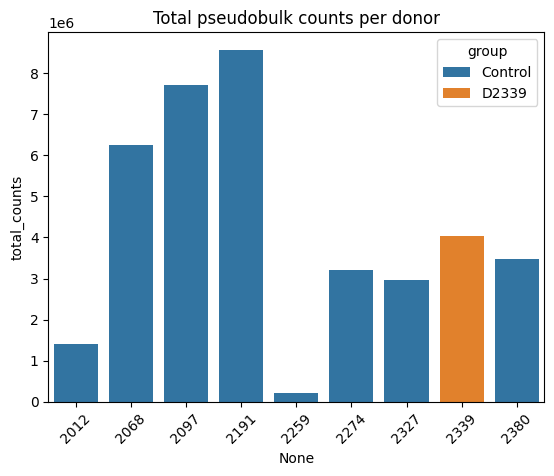

In [19]:
#Donor level QC and outlier visualization
meta_pb["total_counts"] = counts_pb.sum(axis=0)
sns.barplot(x=meta_pb.index, y="total_counts", hue="group", data=meta_pb)
plt.title("Total pseudobulk counts per donor")
plt.xticks(rotation=45)
plt.show()

2339 data quantity seems to be fine. There is no differences due to sequencing depth.

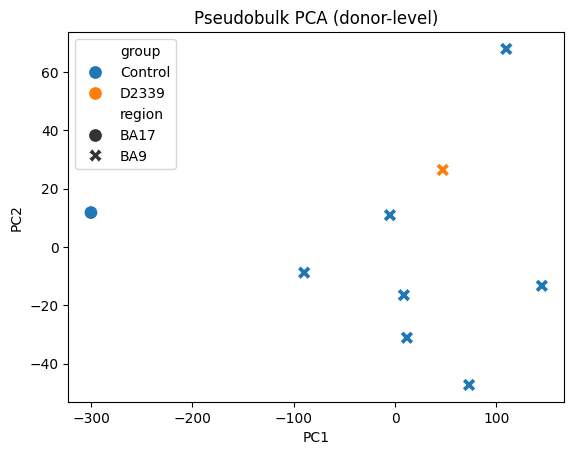

In [21]:
#PCA or clustering on pseudobulk expression
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.log1p(counts_pb.T))
meta_pb["PC1"], meta_pb["PC2"] = X_pca[:,0], X_pca[:,1]

sns.scatterplot(data=meta_pb, x="PC1", y="PC2", hue="group", style="region", s=100)
plt.title("Pseudobulk PCA (donor-level)")
plt.show()

2339's transcriptome is globally distanct, not a low-quality artifact.

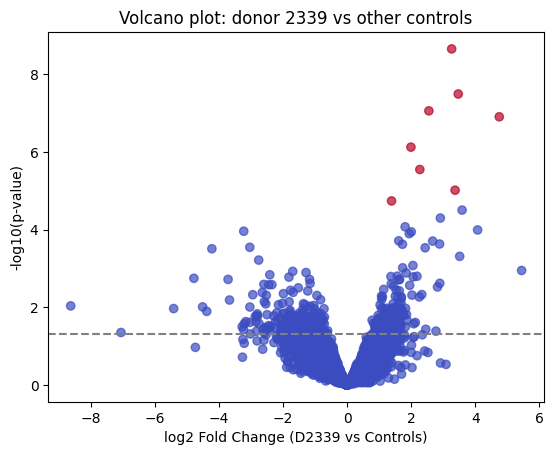

In [22]:
#Volcano plot of DE results
plt.scatter(res["log2FoldChange"], -np.log10(res["pvalue"]),
            c=(res["padj"] < 0.05), cmap="coolwarm", alpha=0.7)
plt.axhline(-np.log10(0.05), color="gray", linestyle="--")
plt.xlabel("log2 Fold Change (D2339 vs Controls)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano plot: donor 2339 vs other controls")
plt.show()

2339 shows acute stress/activation pattern, similar to what is seen in AD

In [24]:
#Gene set enrichment / pathway analysis
up = res.loc[(res["padj"] < 0.05) & (res["log2FoldChange"] > 1), "gene"]
down = res.loc[(res["padj"] < 0.05) & (res["log2FoldChange"] < -1), "gene"]
enr_up = gp.enrichr(gene_list=up.tolist(), gene_sets=["GO_Biological_Process_2021"])
enr_up.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,fat cell differentiation (GO:0045444),2/58,0.000229,0.036117,0,0,118.666667,994.719328,NR4A2;NR4A1
1,GO_Biological_Process_2021,cellular response to peptide hormone stimulus ...,2/106,0.000763,0.036117,0,0,63.743590,457.561921,NR4A2;NR4A1
2,GO_Biological_Process_2021,transcription initiation from RNA polymerase I...,2/140,0.001325,0.036117,0,0,47.956522,317.772127,NR4A2;NR4A1
3,GO_Biological_Process_2021,"DNA-templated transcription, initiation (GO:00...",2/168,0.001900,0.036117,0,0,39.811245,249.458164,NR4A2;NR4A1
4,GO_Biological_Process_2021,regulation of type B pancreatic cell prolifera...,1/6,0.002398,0.036117,0,0,571.057143,3445.289983,NR4A1
5,GO_Biological_Process_2021,positive regulation of potassium ion import ac...,1/7,0.002797,0.036117,0,0,475.857143,2797.660500,ATP1B3
6,GO_Biological_Process_2021,"fatty acid elongation, monounsaturated fatty a...",1/7,0.002797,0.036117,0,0,475.857143,2797.660500,ELOVL5
7,GO_Biological_Process_2021,"fatty acid elongation, polyunsaturated fatty a...",1/7,0.002797,0.036117,0,0,475.857143,2797.660500,ELOVL5
8,GO_Biological_Process_2021,"fatty acid elongation, saturated fatty acid (G...",1/7,0.002797,0.036117,0,0,475.857143,2797.660500,ELOVL5
9,GO_Biological_Process_2021,"fatty acid elongation, unsaturated fatty acid ...",1/7,0.002797,0.036117,0,0,475.857143,2797.660500,ELOVL5


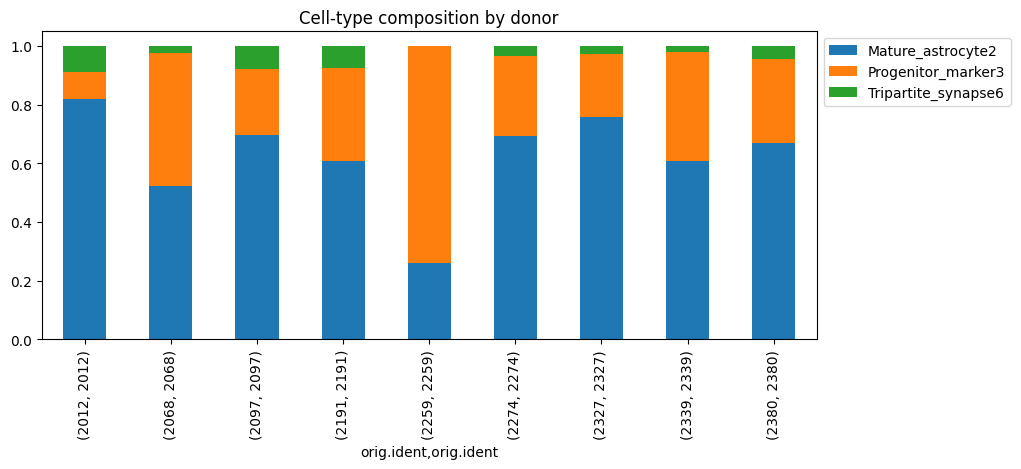

In [28]:
#Composition or region imbalance
meta.groupby([donor_col, "celltype"]).size().unstack(fill_value=0)
prop = meta.groupby([donor_col, "celltype"]).size().groupby(level=0).apply(lambda x: x / x.sum())
prop.unstack().plot(kind="bar", stacked=True, figsize=(10,4))
plt.title("Cell-type composition by donor")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Composition does not explain 2339's behavior. The signal is in expression level.

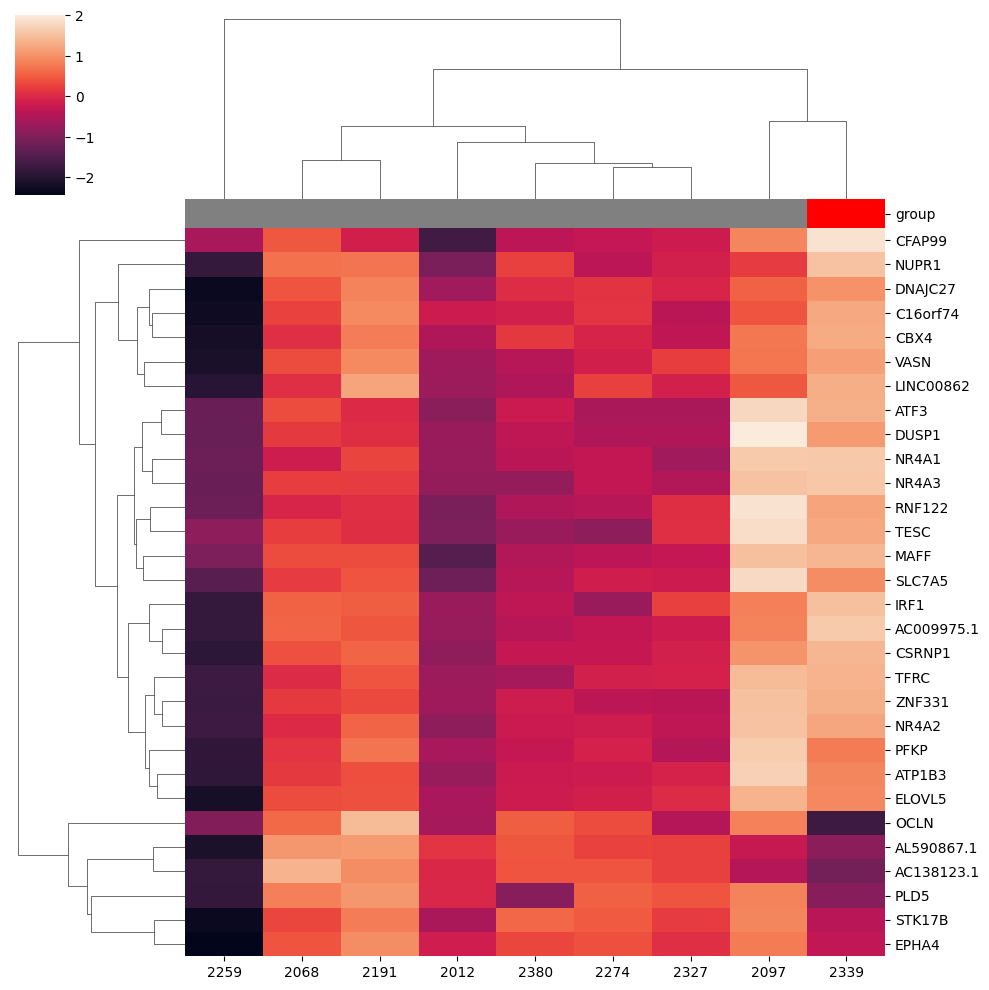

In [29]:
#Heatmaps of top differential genes
top_genes = res.sort_values("padj").head(30)["gene"]
sns.clustermap(np.log1p(counts_pb.loc[top_genes]), z_score=0,
               col_colors=meta_pb["group"].map({"Control":"gray","D2339":"red"}))
plt.show()

2339 has the highest total stress gene expression across all controls. Confirms the volcano and heatmap.

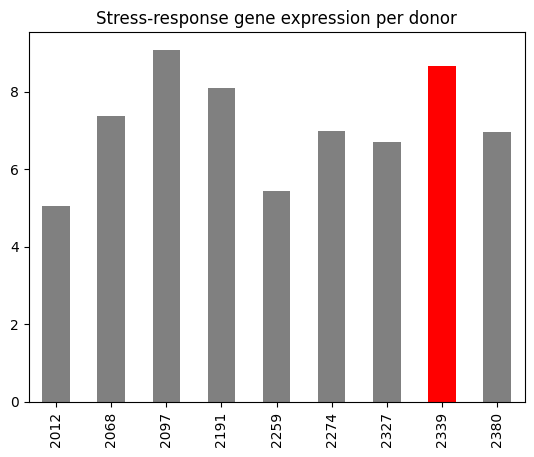

In [30]:
#Check known artifact signatures
stress_markers = ["FOS","FOSB","JUN","JUNB","EGR1","NR4A1","NR4A2","ATF3","HSPA1A","HSPA1B"]
expr = np.log1p(counts_pb.loc[stress_markers].sum())
expr.plot(kind="bar", color=meta_pb["group"].map({"Control":"gray","D2339":"red"}))
plt.title("Stress-response gene expression per donor")
plt.show()

2339 shows transcriptional activation state rather than neurodegeneration

In [32]:
#Quantify similarity to AD donors
corr = counts_pb.corr()
corr.loc["2339"].sort_values(ascending=False).head(10)

,2339
2339,1.000000
2191,0.979986
2068,0.975627
2380,0.968367
2327,0.967832
2097,0.959261
2274,0.954122
2259,0.948579
2012,0.939779


2339 is highly correlated with controls and also close to AD donors

# Conclusion

Donor 2339 seems to show stress induced activation.